# Convolutional Neural Networks
This assignment aims to implement a CNN using the PyTorch deep learning framework.

Modified by Kien Nguyen, Oct 2022

You will learn how to prepare the data, define the model, train and test your model. 

**Note**:
- If you do not have sufficient computational power (i.e., no access to GPU), please use Google Collab for this assignment. It is a fairly easy to use Jupyter Notebook. Before running your code on Collab, go to ``Runtime`` $\rightarrow$ ``Change runtime type``, choose **GPU** on the dropdown menu and ``Save``.

**Overview:**
- Data Processing:
    - Data Normalization/Standardization
    - Data Augmentation
- Architectures:
    - Design and train a CNN model
    - **[LeNet](https://www.wikiwand.com/en/LeNet)** and **[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)** are recommended as references.
    - Other architectures, i.e. ResNet, VGG, Inception are also suggested (but may require more computational expense).
    - Regularization
        - Dropout
        - L2 Norm
        - etc.
- Hyperparameter tuning:
    - Learning rate:
        - Try at least **three different** learning rates.
    - Optimizer:
        - Try at least **three different** optimizers, e.g. *SGD, RMSprop, Adam* and *etc*.

## 1 - Packages
Import the necessary packages

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
%matplotlib inline

## 2 - Training Parameters
Define some hyper-parameters for the training process. Try changing these hyper-parameters and observe the performance of the model.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # using gpu or cpu
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
num_classes = 10 # number of classes
batch_size = 100
num_epochs = 20 # to get a better result, you can increase the number of epochs

learning_rates = [0.001, 0.01, 0.0001] # suggested range [1e-2, 1e-4]
optimizers = ['sgd', 'rmsprop', 'adam']

## 3 - Data Loader and Augmentation [5 points]
We will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) as our dataset. Pytorch provide functions to download this dataset, you don't have to do download it from the official website. In this section, you will become familiar with the data loading pipeline of PyTorch.

- Normalize all the images to help remove gross bias within the data and to place us numerically within a known range for any input data.

- Implement data augmentations for the training see (see more [here](https://pytorch.org/vision/stable/transforms.html)):
    - RandomCrop, RandomHorizontalFlip, RandomRotation, etc.
    
- More info [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [8]:
# Data augmentation
transform_train = transforms.Compose([
    ### START CODE HERE ### (≈ 3 lines of code)
    # Fill in data augmentations
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    ### END CODE HERE ###
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Don't augment the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 4 - Define the Networks [15 points]
This section defines the architecture of the network. We provide the output dimension of each layer's output. Use this information to define the appropriate convolutional, max pooling and fully-connected (linear) layers in PyTorch with the code skeleton provided below. There might be multiple solutions to achieve the specified dimensions; it is required that the number of parameters in the network cannot exceed 3 million. We provide a code segment for you to check the number of parameters below. Here, m denotes the batch size. The forward pass is also defined.

- Input: (m, 3, 32, 32)
- After ``conv1``: (m, 64, 16, 16)
- After ``maxpool1``: (m, 64, 8, 8)
- After ``conv2``: (m, 192, 8, 8)
- After ``maxpool2``: (m, 192, 4, 4)
- After ``conv3``: (m, 384, 4, 4)
- After ``maxpool3``: (m, 384, 2, 2)
- After ``conv4``: (m, 256, 2, 2)
- After ``maxpool4``: (m, 256, 1, 1)
- After ``fc1``: (m, 512)
- After ``fc2``: (m, 512)
- After ``fc3`` (Output): (m, 10)

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def observe_outputs(self, x): # used to observe the dimension of each layer's output
        x = self.conv1(x)
        print(f'After conv1: {x.size()}')
        x = self.maxpool1(F.relu(x))
        print(f'After maxpool1: {x.size()}')

        x = self.conv2(x)
        print(f'After conv2: {x.size()}')
        x = self.maxpool2(F.relu(x))
        print(f'After maxpool2: {x.size()}')

        x = self.conv3(x)
        print(f'After conv3: {x.size()}')
        x = self.maxpool3(F.relu(x))
        print(f'After maxpool3: {x.size()}')

        x = self.conv4(x)
        print(f'After conv4: {x.size()}')
        x = self.maxpool4(F.relu(x))
        print(f'After maxpool4: {x.size()}')

        # flatten to a vector
        x = x.view(x.size(0), 256)
        print(f'Flatten: {x.size()}')

        x = F.relu(self.fc1(x))
        print(f'After fc1: {x.size()}')
        x = F.relu(self.fc2(x))
        print(f'After fc2: {x.size()}')
        x = self.fc3(x)
        print(f'After fc3: {x.size()}')
        return x

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(F.relu(x))

        x = self.conv2(x)
        x = self.maxpool2(F.relu(x))

        x = self.conv3(x)
        x = self.maxpool3(F.relu(x))

        x = self.conv4(x)
        x = self.maxpool4(F.relu(x))

        # flatten to a vector
        x = x.view(x.size(0), 256)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

Run the block of code below to confirm each layer's output dimension matches the requirements.

In [10]:
def test_forward(): # This function displays each layer's output dimension
    model = Model().to(device)
    x = torch.randn(16, 3, 32, 32).to(device)
    with torch.no_grad():
        model.observe_outputs(x)

test_forward()


After conv1: torch.Size([16, 64, 16, 16])
After maxpool1: torch.Size([16, 64, 8, 8])
After conv2: torch.Size([16, 192, 8, 8])
After maxpool2: torch.Size([16, 192, 4, 4])
After conv3: torch.Size([16, 384, 4, 4])
After maxpool3: torch.Size([16, 384, 2, 2])
After conv4: torch.Size([16, 256, 2, 2])
After maxpool4: torch.Size([16, 256, 1, 1])
Flatten: torch.Size([16, 256])
After fc1: torch.Size([16, 512])
After fc2: torch.Size([16, 512])
After fc3: torch.Size([16, 10])


Run the block of code below to confirm your network has fewer than 30 millions parameters.

In [ ]:
def count_parameters(net, all=True):
    # If all == False, we only return the trainable parameters
    return sum(p.numel() for p in net.parameters() if p.requires_grad or all)

num_params = count_parameters(Model())
print(f'Total number of parameters: {num_params}')


## 5 - Loss and Optimizer [5 points for Section 5 to 7]
This section initializes the ``Model`` class, and defines the loss function and optimizer. We are doing multi-class classification, so we use the cross-entropy loss. The standard optimizers are Stochastic Gradient Descent (SGD) and Adam. You can find more optimizers [here](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer).

In [11]:
# initialize the model and send it to GPU using torch.Tensor.to()
model = Model().to(device)

# initialize cross-entropy loss
criterion = nn.CrossEntropyLoss()

# initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters())


## 6 - Define the Training Loop
This section will learn how to train the model: get batches, calculate loss, and update model.

A standard PyTorch training loop consists of:

- Getting the prediction for each batch.
- Calculate the loss on the prediction versus the true label (ground truth).
- Calculate the gradients.
- Update the model's weights/parameters using the optimizer and the gradients computed in the previous step.

Also, do not forget to (optional):

- Keep track of the loss values to plot the training loss later
- Clear out the old gradients in the optimizer every iteration before calculating the new ones.
- Frequently print out the accuracy of the model to see if the learning is on the right track.

Please fill in the missing codes.

In [12]:
# Train the model
def train(epoch, model, criterion, optimizer):
    print('\nEpoch: %d' % epoch)
    train_losses = [] # needed for visualize the traning loss
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)# get a batch 
        ### START CODE HERE ### (≈ 5 lines of code)
        # Clear gradient
        optimizer.zero_grad()
        # Forward pass batch through model
        outputs = model(inputs)
        # Calculate loss on batch
        loss = criterion(outputs, targets)
        # Calculate gradients for backward pass
        loss.backward()
        # Update model
        optimizer.step()
        ### END CODE HERE ###

        train_loss += loss.item()
        train_losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 0: # print every 100 iterations
            print(batch_idx, len(trainloader), 'Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_losses, 100.*correct/total


## 7 - Define the Testing Loop
This section will learn how to test the trained model and save the best model.

A standard PyTorch testing loop consists of:

- Getting the predictions and calculate the accuracy over the whole testing set.

Do not forget to:

- Disable the gradients on the model upon making predictions (i.e., ``torch.no_grad()``).
- Save the best model's weights ([reference](https://pytorch.org/tutorials/beginner/saving_loading_models.html)).

Please fill in the missing codes.

In [13]:
def test(epoch, model, criterion, optimizer, optimizer_function, learning_rate):
    global best_acc
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            ### START CODE HERE ### (≈ 2 lines of code)
            # Forward pass batch through model
            outputs = model(inputs)
            # Calculate loss on batch
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 0:
                print(batch_idx, len(testloader), 'Testing Loss: %.3f | Acc: %.3f%% (%d/%d)'
                            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save best model.
    acc = 100.*correct/total
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))
    if acc > best_acc:
        print('Start Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/ckpt_{optimizer_function}_lr_{learning_rate}.pth')
        best_acc = acc
        print('Done Saving!')
    return test_losses, acc


## 8 - Model Training and Testing

Run the training and testing loops to conduct the training process.

In [14]:
accuracy_dict = dict()
acc_epochs_train = []
acc_epochs_test = []
for optimizer_function in optimizers: # ['sgd', 'rmsprop', 'adam']
    for learning_rate in learning_rates:
        model = Model().to(device)
        criterion = nn.CrossEntropyLoss()
        if optimizer_function == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), learning_rate)
        elif optimizer_function == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), learning_rate)
        elif optimizer_function == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), learning_rate)
        best_acc=0
        for epoch in range(start_epoch, start_epoch + num_epochs):
            l_tr, acc_tr = train(epoch, model, criterion, optimizer)
            l_te, acc_te = test(epoch, model, criterion, optimizer, optimizer_function, learning_rate)
            acc_epochs_train.append(acc_tr)
            acc_epochs_test.append(acc_te)
        accuracy_dict[f'Optimizer {optimizer_function} - lr_{learning_rate}'] = acc_te
for key, value in accuracy_dict.items():
    print(f'{key} - Accuracy = {value}')
    


Epoch: 0
0 500 Train Loss: 2.301 | Acc: 6.000% (6/100)
100 500 Train Loss: 2.303 | Acc: 9.772% (987/10100)
200 500 Train Loss: 2.303 | Acc: 9.721% (1954/20100)
300 500 Train Loss: 2.303 | Acc: 9.824% (2957/30100)
400 500 Train Loss: 2.303 | Acc: 10.015% (4016/40100)
0 100 Testing Loss: 2.301 | Acc: 11.000% (11/100)
Test Accuracy of the model on the 10000 test images: 10.27 %
Start Saving..
Done Saving!

Epoch: 1
0 500 Train Loss: 2.303 | Acc: 9.000% (9/100)
100 500 Train Loss: 2.303 | Acc: 10.198% (1030/10100)
200 500 Train Loss: 2.302 | Acc: 10.284% (2067/20100)
300 500 Train Loss: 2.302 | Acc: 10.392% (3128/30100)
400 500 Train Loss: 2.303 | Acc: 10.252% (4111/40100)
0 100 Testing Loss: 2.301 | Acc: 11.000% (11/100)
Test Accuracy of the model on the 10000 test images: 10.82 %
Start Saving..
Done Saving!

Epoch: 2
0 500 Train Loss: 2.304 | Acc: 9.000% (9/100)
100 500 Train Loss: 2.302 | Acc: 10.099% (1020/10100)
200 500 Train Loss: 2.302 | Acc: 10.433% (2097/20100)
300 500 Train Loss

KeyboardInterrupt: 

## 9 - Report your Results [25 points]

- You have to report the followings in a separate PDF:
    - The number of parameters in your CNN.
    - The best accuracy on the testing set (along with the training training set). You will get full credit if your model achieves $ > 70\%$ accuracy on the testing set.
    - F1 score on the testing set from the model with the best accuracy. There is no provided code for this; please implement F1 score.
    - A plot containing the **training and testing accuracies** with respect to time (epochs).
    - A plot containing the **training and testing losses** with respect to time (epochs).
    - Try 2 more learning rates with the Adam optimizer and report the accuracy and F1 score for both.
    - Try 2 more optimizers with a fixed learning rate of 0.01 and report the accuracy and F1 score for both.
    - Trying different learning rates and optimizers is also known as Ablation Study. Organize your results in a table for ease of readability. Please give some insights on the performances of different settings.
    - Finally, please submit the notebook **that contains the output logs**.

## Extra - Evaluation from Checkpoint (Optional)
This section will show you how to load the saved model.

In [25]:
model = Model().to(device)
checkpoint = torch.load('./checkpoint/ckpt_adam_lr_0.001.pth', map_location=torch.device('cpu')) # load checkpoint
model.load_state_dict(checkpoint['net']) # load model parameter

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        ### START CODE HERE ### (≈ 2 lines of code)
        # Forward pass real batch through model
        outputs = model(inputs)
        # Calculate loss on all-real batch
        loss = criterion(outputs, targets)
        ### END CODE HERE ###

        test_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
acc = 100.*correct/total
print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))


Test Accuracy of the model on the 10000 test images: 72.34 %


## Extra - Plot the Training Loss  

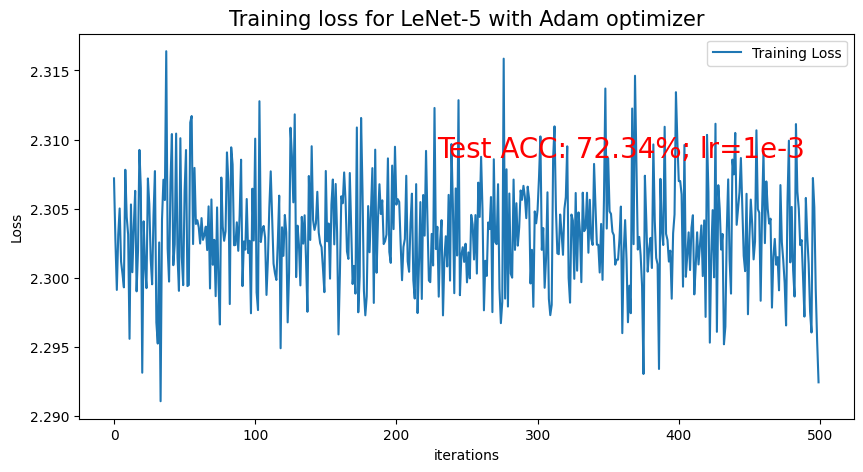

In [26]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.title("Training loss for LeNet-5 with Adam optimizer", fontsize=15)
plt.plot(l_tr,label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
ax.text(0.7, 0.7, f'Test ACC: {acc}%; lr=1e-3',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=20, color='red')
plt.legend()
plt.show()
